In [1]:
import IPython
from IPython.display import Image, Audio
from midi2audio import FluidSynth
from music21 import corpus, converter, instrument, note, stream, chord, duration
import matplotlib.pyplot as plt
import time

import os
import pickle
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

import os
import numpy as np
import glob

from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K 
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

from keras.utils import np_utils
import seaborn as sns

In [2]:
dataset_name = 'C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach'
filename = 'bach_846'
file = "{}/{}.mid".format(dataset_name, filename)

original_score = converter.parse(file).chordify()

In [3]:
fs = FluidSynth()
file = 'C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach/bach_846.mid'
fs.midi_to_audio(file, 'bach_846.wav')
IPython.display.Audio("bach_846.wav") 

FileNotFoundError: [WinError 2] Не удается найти указанный файл

In [4]:
notes = []
durations = []

for element in original_score.flat:    
    if isinstance(element, chord.Chord):
        notes.append('.'.join(n.nameWithOctave for n in element.pitches))
        durations.append(element.duration.quarterLength)

    if isinstance(element, note.Note):
        if element.isRest:
            notes.append(str(element.name))
            durations.append(element.duration.quarterLength)
        else:
            notes.append(str(element.nameWithOctave))
            durations.append(element.duration.quarterLength) 

In [5]:
print('\nduration', 'pitch')
idx = 0
for n,d in zip(notes,durations):
    if idx < 50:
        print(d, '\t', n)
    idx = idx + 1  


duration pitch
0.25 	 C4
0.25 	 C4.E4
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4
0.25 	 C4.E4
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4.E4.G4
0.25 	 C4.E4.C5
0.25 	 C4.E4.E5
0.25 	 C4
0.25 	 C4.D4
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4
0.25 	 C4.D4
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 C4.D4.A4
0.25 	 C4.D4.D5
0.25 	 C4.D4.F5
0.25 	 B3
0.25 	 B3.D4
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3
0.25 	 B3.D4
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 B3.D4.G4
0.25 	 B3.D4.D5
0.25 	 B3.D4.F5
0.25 	 C4
0.25 	 C4.E4


In [6]:
def get_music_list(data_folder):    
    file_list = glob.glob(os.path.join(data_folder, "*.mid"))
    parser = converter    
    return file_list, parser

def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256, use_attention = False):
    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 
    x = Concatenate()([x1,x2])
    x = LSTM(rnn_units, return_sequences=True)(x)

    if use_attention:
        x = LSTM(rnn_units, return_sequences=True)(x)
        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)
        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)    
    else:
        c = LSTM(rnn_units)(x)
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])    

    if use_attention:
        att_model = Model([notes_in, durations_in], alpha)
    else:
        att_model = None
        
    opti = RMSprop(lr = 0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)

    return model, att_model


def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))
    return (element_to_int, int_to_element)    

def prepare_sequences(notes, durations, lookups, distincts, seq_len =32):
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups
    note_names, n_notes, duration_names, n_durations = distincts

    notes_network_input = []
    notes_network_output = []
    durations_network_input = []
    durations_network_output = []

    # create input sequences and the corresponding outputs
    for i in range(len(notes) - seq_len):
        notes_sequence_in = notes[i:i + seq_len]
        notes_sequence_out = notes[i + seq_len]
        notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
        notes_network_output.append(note_to_int[notes_sequence_out])

        durations_sequence_in = durations[i:i + seq_len]
        durations_sequence_out = durations[i + seq_len]
        durations_network_input.append([duration_to_int[char] for char in durations_sequence_in])
        durations_network_output.append(duration_to_int[durations_sequence_out])

    n_patterns = len(notes_network_input)

    # reshape the input into a format compatible with LSTM layers
    notes_network_input = np.reshape(notes_network_input, (n_patterns, seq_len))
    durations_network_input = np.reshape(durations_network_input, (n_patterns, seq_len))
    network_input = [notes_network_input, durations_network_input]

    notes_network_output = np_utils.to_categorical(notes_network_output, num_classes=n_notes)
    durations_network_output = np_utils.to_categorical(durations_network_output, num_classes=n_durations)
    network_output = [notes_network_output, durations_network_output]
    return (network_input, network_output)

def sample_with_temp(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [7]:
# run params
run_folder = 'C:/Users/slava/Desktop/PhishingML/venv/Scripts/'

store_folder = os.path.join(run_folder, 'store')
data_folder ='C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach'

if not os.path.exists('store'):
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))

mode = 'build'

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [8]:
if mode == 'build':    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        print(file)
        original_score = parser.parse(file).chordify()        
        for interval in intervals:
            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)
                        
                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) 
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f)
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

3 files in total
1 Parsing C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_846.mid
C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_846.mid
2 Parsing C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_847.mid
C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_847.mid
3 Parsing C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_850.mid
C:/Users/slava/Desktop/PhishingML/venv/Scripts/classical_music_midi/bach\bach_850.mid


In [9]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [10]:
print('\nnote_to_int')
for i, item in enumerate(note_to_int.items()):
    if i < 10:
        print(item)


note_to_int
('A2', 0)
('A2.A3.A4', 1)
('A2.A3.A4.C#5', 2)
('A2.A3.A4.E5.F#5.G5', 3)
('A2.A3.A4.F5', 4)
('A2.A3.C4.A4', 5)
('A2.A3.D4.F#4', 6)
('A2.A3.D5.F5', 7)
('A2.A3.F5', 8)
('A2.A3.G4', 9)


In [11]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 0.75: 7,
 1.0: 8,
 2.0: 9,
 3.0: 10}

In [12]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [13]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch target')
print(network_output[0][0])
print('duration target')
print(network_output[1][0])

pitch input
[1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333
 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333 1333
 1333 1333 1333 1333]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch target
[0. 0. 0. ... 0. 0. 0.]
duration target
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    133400      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    1100        ['input_2[0][0]']                
                                                                                              

c:\users\slava\desktop\phishingml\venv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [16]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=200, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/200
75/75 [==============================] - 21s 226ms/step - loss: 7.5062 - pitch_loss: 6.8445 - duration_loss: 0.6617 - val_loss: 8.6307 - val_pitch_loss: 7.4674 - val_duration_loss: 1.1633
Epoch 2/200
75/75 [==============================] - 17s 233ms/step - loss: 6.6387 - pitch_loss: 6.1725 - duration_loss: 0.4662 - val_loss: 8.5204 - val_pitch_loss: 7.3908 - val_duration_loss: 1.1296
Epoch 3/200
75/75 [==============================] - 16s 220ms/step - loss: 6.3129 - pitch_loss: 5.8983 - duration_loss: 0.4146 - val_loss: 9.5960 - val_pitch_loss: 8.4743 - val_duration_loss: 1.1218
Epoch 4/200
75/75 [==============================] - 16s 219ms/step - loss: 6.1001 - pitch_loss: 5.7186 - duration_loss: 0.3814 - val_loss: 10.5925 - val_pitch_loss: 9.1591 - val_duration_loss: 1.4334
Epoch 5/200
75/75 [==============================] - 16s 214ms/step - loss: 5.9365 - pitch_loss: 5.5609 - duration_loss: 0.3756 - val_loss: 9.6774 - val_pitch_loss: 8.4717 - val_duration_loss: 1.2057

In [17]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [18]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []
overall_preds = []

for n, d in zip(notes,durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)
    
    prediction_output.append([n, d])
    
    if n != 'START':
        midi_note = note.Note(n)
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape = (max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):

    prediction_input = [
        np.array([notes_input_sequence])
        , np.array([durations_input_sequence])
       ]

    notes_prediction, durations_prediction = model.predict(prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[(note_index-len(att_prediction)+sequence_length):(note_index+sequence_length), note_index] = att_prediction
    
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i            
        except:
            pass
        
    overall_preds.append(new_note)            
    
    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)    

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds)) 
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


Text(0.5, 1.0, 'Probability distribution of the next possible note over time')

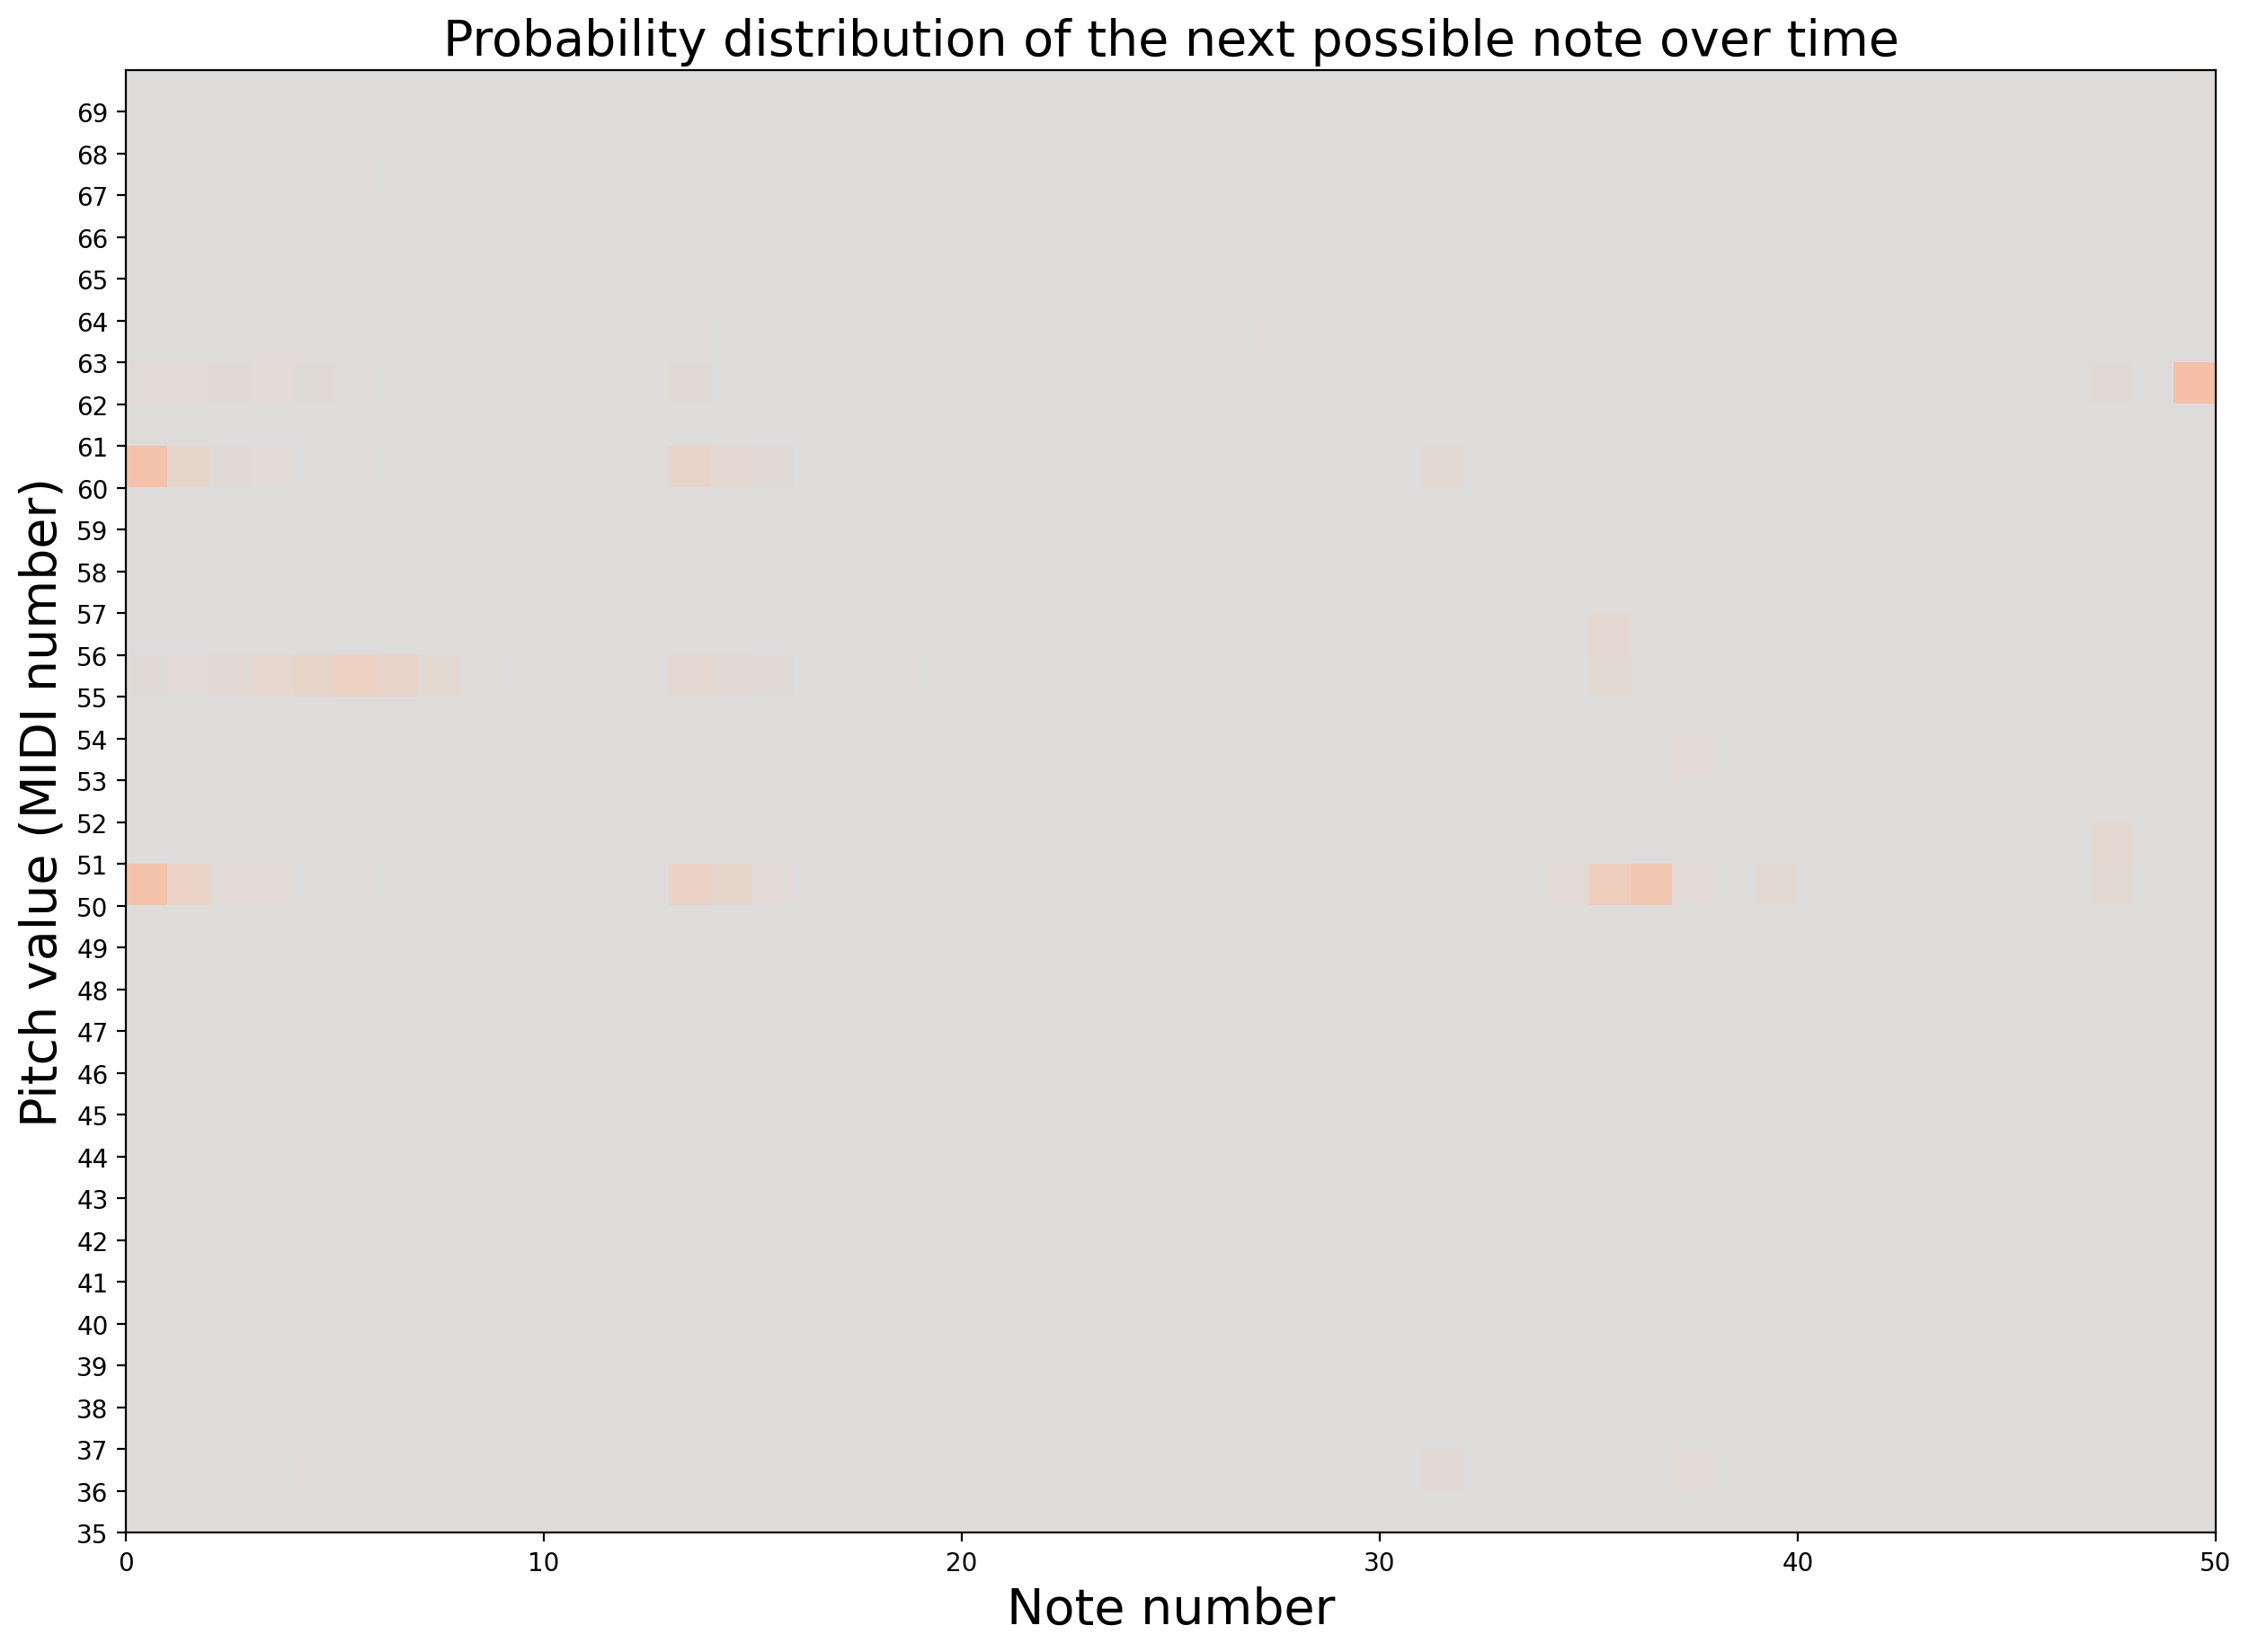

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35,70)])
plt.imshow(overall_preds[35:70,:], origin="lower", cmap='coolwarm', vmin = -0.5, vmax = 0.5, extent=[0, max_extra_notes, 35,70])
plt.xlabel("Note number",fontsize=20)
plt.ylabel("Pitch value (MIDI number)",fontsize=20)
plt.title("Probability distribution of the next possible note over time",fontsize=20)

In [20]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
    # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
    # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)

midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
new_file = 'output-' + timestr + '.mid'
midi_stream.write('midi', fp=os.path.join(output_folder, new_file))

'C:/Users/slava/Desktop/PhishingML/venv/Scripts/output\\output-20240611-090502.mid'

In [29]:
new_path = 'C:/Users/slava/Desktop/PhishingML/venv/Scripts/output/'+new_file
fs = FluidSynth()
fs.midi_to_audio(new_path, 'new_output.wav')

FileNotFoundError: [WinError 2] Не удается найти указанный файл